In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/creditcardfraud


*# Analizando Columnas*

---

*DESCRIPCIÓN DE VARIABLES*
----------------------------------------
Significado de las variables:
- Time: Segundos transcurridos entre cada transacción y la primera del dataset
- Amount: Monto de la transacción
- V1-V28: Componentes principales obtenidas mediante PCA (transformaciones de las características originales)
- Class: Variable objetivo (1 = Fraude, 0 = No Fraude)

Tipo de codificación de variables:
- Time: Numérica (continua) - Tiempo en segundos
- Amount: Numérica (continua) - Monto en unidades monetarias
- V1-V28: Numérica (continua) - Componentes PCA normalizadas
- Class: Categórica binaria (0/1) - Indica presencia de fraude

In [2]:
!pip install imbalanced-learn

In [3]:
#Análisis Exploratorio de Datos para Detección de Fraude en Tarjetas de Crédito
# ==================================================================

# 1. CONFIGURACIÓN INICIAL Y CARGA DE DATOS
# -----------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, SelectKBest, f_classif
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_recall_curve

# Importamos herramientas específicas para datos desbalanceados
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.metrics import sensitivity_specificity_support, geometric_mean_score, classification_report_imbalanced


# Configuración de visualizaciones para consola
%matplotlib inline
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
pd.set_option('display.max_columns', 50)


In [4]:
import os
files = os.listdir('/kaggle/input/creditcardfraud')
print("Files in dataset directory:", files)

# Load the CSV into a DataFrame
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')

Files in dataset directory: ['creditcard.csv']



2. EXPLORACIÓN INICIAL DEL DATASET

Dimensiones del dataset: 284807 filas, 31 columnas

Primeras 5 filas del dataset:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10       V11       V12       V13       V14  \
0  0.098698  0.363787  0.090794 -0.551600 -0.617801 -0.991390 -0.311169   
1  0.085102 -0.255425 -0.166974  1.612727  1.065235  0.489095 -0.143772   
2  0.247676 -1.514654  0.207643  0.624501  0.066084  0.717293 -0.165946   
3  0.377436 -1.387024 -0.054952 -0.226487  0.178228  0.507757 -0.287924   
4 -0.270533  0.8177

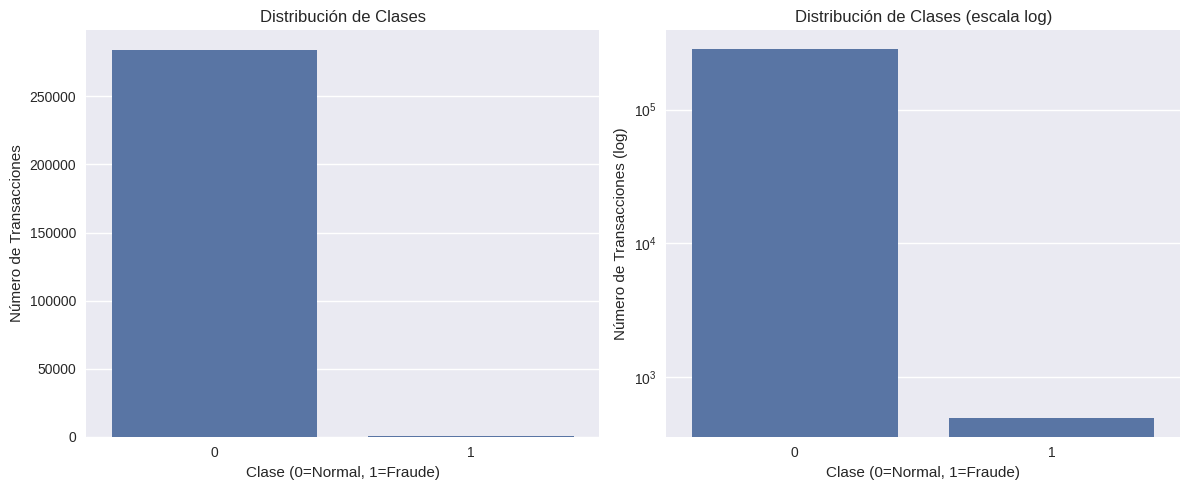

In [5]:
# 2. EXPLORACIÓN INICIAL DEL DATASET
# ---------------------------------
print("\n2. EXPLORACIÓN INICIAL DEL DATASET")
print("="*80)

# Información básica del dataset
print(f"\nDimensiones del dataset: {df.shape[0]} filas, {df.shape[1]} columnas")
print("\nPrimeras 5 filas del dataset:")
print(df.head())

# Información de tipos y valores no nulos
print("\nInformación del dataset:")
df.info()

# Estadísticas descriptivas
print("\nEstadísticas descriptivas:")
print(df.describe())

# 3. ANÁLISIS DE VALORES FALTANTES
# -------------------------------
print("\n3. ANÁLISIS DE VALORES FALTANTES")
print("="*80)

# Verificamos valores nulos
null_counts = df.isnull().sum()
null_percent = 100 * null_counts / len(df)

# Mostramos solo columnas con valores nulos
null_cols = null_counts[null_counts > 0]
if len(null_cols) > 0:
    print("\nColumnas con valores nulos:")
    for col in null_cols.index:
        print(f"- {col}: {null_counts[col]} valores nulos ({null_percent[col]:.2f}%)")

    # Imputamos valores faltantes para análisis exploratorio
    print("\nRealizando imputación de valores faltantes:")
    imputer = SimpleImputer(strategy='median')
    df_imputed = pd.DataFrame(
        imputer.fit_transform(df),
        columns=df.columns
    )
    print("Valores faltantes imputados con la mediana de cada columna.")
    df = df_imputed
else:
    print("\nNo se encontraron valores nulos en el dataset.")

# Verificamos infinitos o valores extremos
inf_mask = np.isinf(df.values)
inf_count = inf_mask.sum()

if inf_count > 0:
    print(f"\nSe encontraron {inf_count} valores infinitos. Reemplazándolos...")
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    # Imputamos los nuevos NaN
    imputer = SimpleImputer(strategy='median')
    df = pd.DataFrame(
        imputer.fit_transform(df),
        columns=df.columns
    )
    print("Valores infinitos reemplazados e imputados.")

# 4. ANÁLISIS DE DESBALANCE DE CLASES
# ----------------------------------
print("\n4. ANÁLISIS DE DESBALANCE DE CLASES")
print("="*80)

# Distribución de clases
class_counts = df['Class'].value_counts()
class_pct = 100 * class_counts / len(df)

print("\nDistribución de clases:")
for i, count in enumerate(class_counts):
    print(f"- Clase {i}: {count} muestras ({class_pct[i]:.4f}%)")

# Calculamos ratio de desbalance
imbalance_ratio = class_counts[0] / class_counts[1] if 1 in class_counts.index else float('inf')
print(f"\nRatio de desbalance: 1:{imbalance_ratio:.1f}")

# Visualizamos el desbalance
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(x='Class', data=df)
plt.title('Distribución de Clases')
plt.xlabel('Clase (0=Normal, 1=Fraude)')
plt.ylabel('Número de Transacciones')

plt.subplot(1, 2, 2)
sns.countplot(x='Class', data=df)
plt.title('Distribución de Clases (escala log)')
plt.xlabel('Clase (0=Normal, 1=Fraude)')
plt.ylabel('Número de Transacciones (log)')
plt.yscale('log')

plt.tight_layout()
plt.show()



5. ANÁLISIS DE LAS VARIABLES NO TRANSFORMADAS

Analizando variables Time y Amount:

Estadísticas de Time:
count    284807.000000
mean      94813.859575
std       47488.145955
min           0.000000
25%       54201.500000
50%       84692.000000
75%      139320.500000
max      172792.000000
Name: Time, dtype: float64

Estadísticas de Amount:
count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64


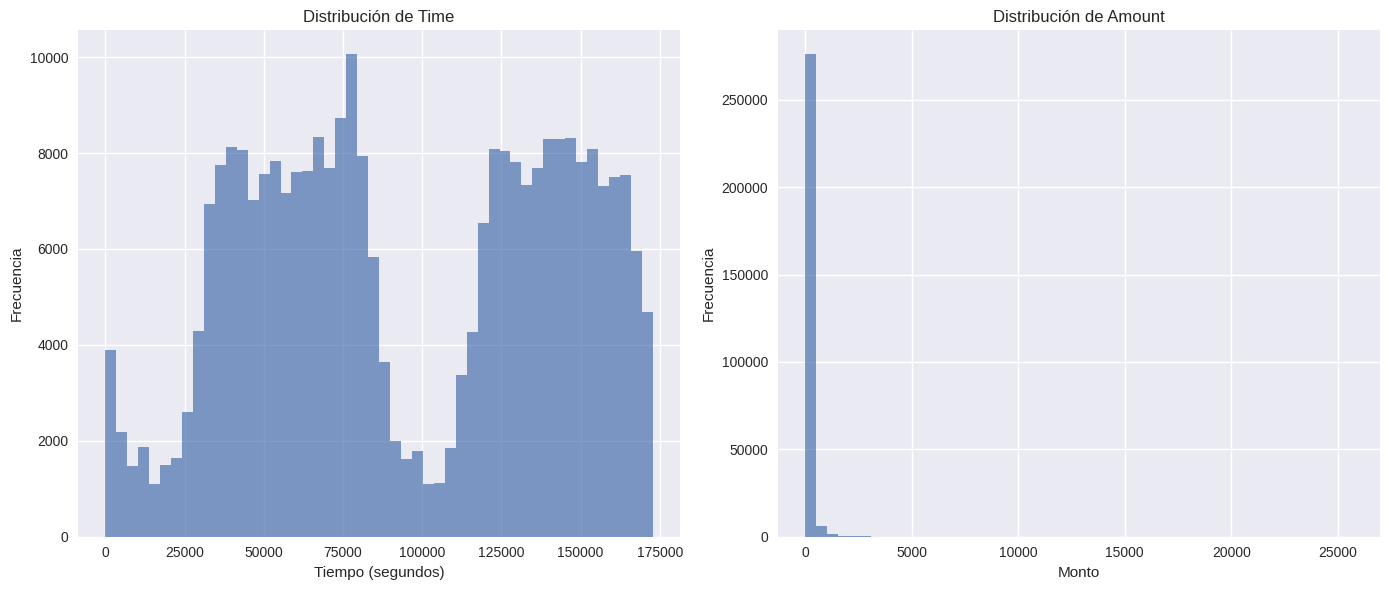

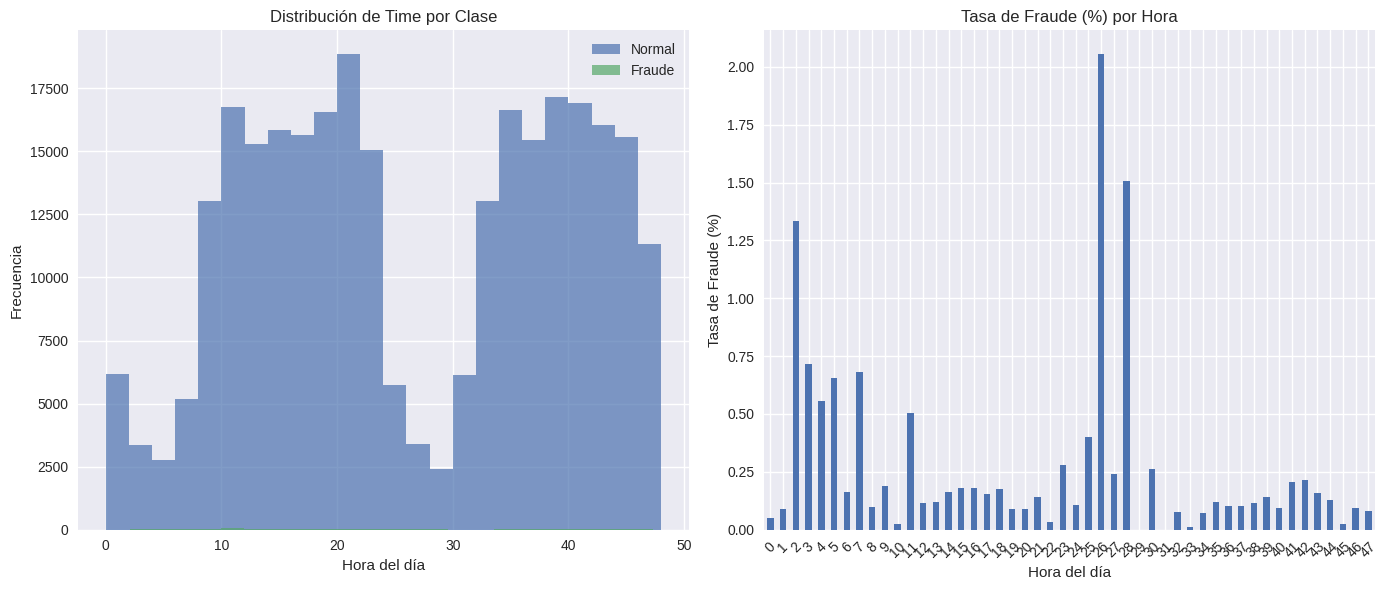

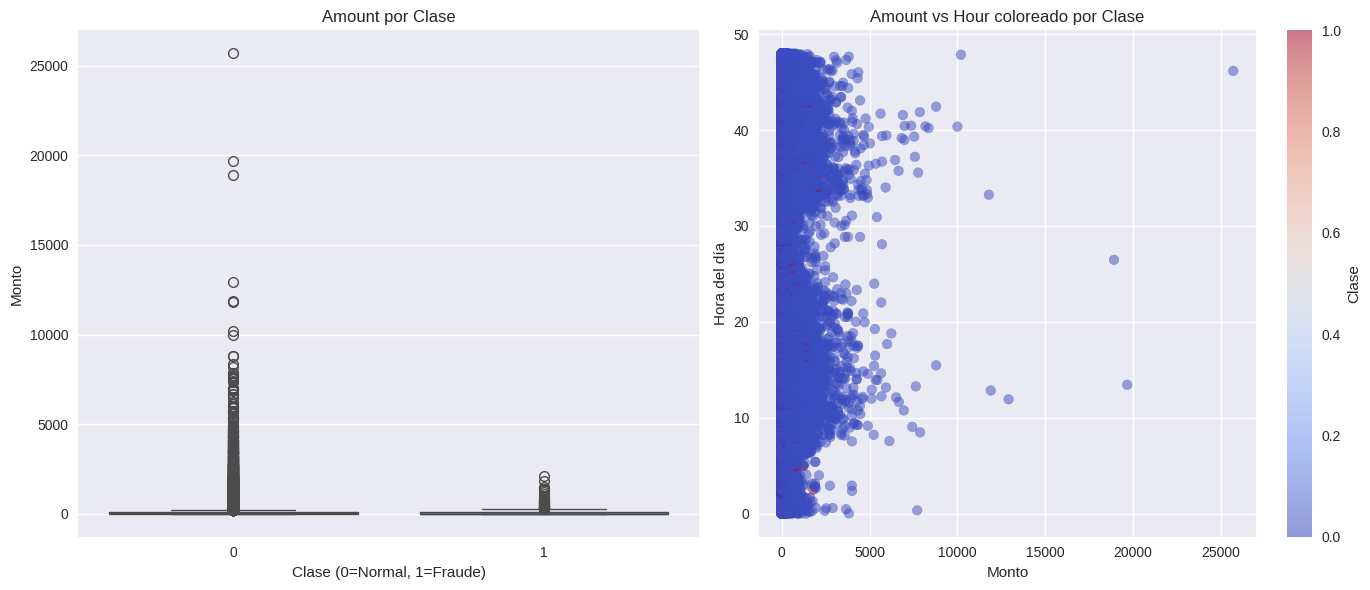

In [6]:
# 5. ANÁLISIS DE LAS VARIABLES NO TRANSFORMADAS
# -------------------------------------------
print("\n5. ANÁLISIS DE LAS VARIABLES NO TRANSFORMADAS")
print("="*80)

# Time y Amount son las únicas variables no transformadas por PCA
print("\nAnalizando variables Time y Amount:")

# Estadísticas de Time y Amount
print("\nEstadísticas de Time:")
print(df['Time'].describe())
print("\nEstadísticas de Amount:")
print(df['Amount'].describe())

# Visualizamos Time y Amount
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(df['Time'], bins=50, alpha=0.7)
plt.title('Distribución de Time')
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Frecuencia')

plt.subplot(1, 2, 2)
plt.hist(df['Amount'], bins=50, alpha=0.7)
plt.title('Distribución de Amount')
plt.xlabel('Monto')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

# Convertimos Time a una medida más interpretable (horas)
df['Hour'] = df['Time'] / 3600

# Visualizamos Time por clase
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(df[df['Class']==0]['Hour'], bins=24, alpha=0.7, label='Normal')
plt.hist(df[df['Class']==1]['Hour'], bins=24, alpha=0.7, label='Fraude')
plt.title('Distribución de Time por Clase')
plt.xlabel('Hora del día')
plt.ylabel('Frecuencia')
plt.legend()

# Calculamos y visualizamos tasa de fraude por hora
hourly_fraud_rate = df.groupby(df['Hour'].astype(int))['Class'].mean() * 100

plt.subplot(1, 2, 2)
hourly_fraud_rate.plot(kind='bar')
plt.title('Tasa de Fraude (%) por Hora')
plt.xlabel('Hora del día')
plt.ylabel('Tasa de Fraude (%)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Visualizamos Amount por clase
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='Class', y='Amount', data=df)
plt.title('Amount por Clase')
plt.xlabel('Clase (0=Normal, 1=Fraude)')
plt.ylabel('Monto')

plt.subplot(1, 2, 2)
plt.scatter(df['Amount'], df['Hour'], c=df['Class'], alpha=0.5, cmap='coolwarm')
plt.title('Amount vs Hour coloreado por Clase')
plt.xlabel('Monto')
plt.ylabel('Hora del día')
plt.colorbar(label='Clase')

plt.tight_layout()
plt.show()



6. ANÁLISIS DE COMPONENTES PRINCIPALES (V1-V28)

Número de componentes PCA: 28

Estadísticas de las componentes PCA:
                 V1            V2            V3            V4            V5  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15  9.604066e-16   
std    1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00  1.380247e+00   
min   -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00 -1.137433e+02   
25%   -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01 -6.915971e-01   
50%    1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02 -5.433583e-02   
75%    1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01  6.119264e-01   
max    2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01  3.480167e+01   

                 V6            V7            V8            V9           V10  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   1.487

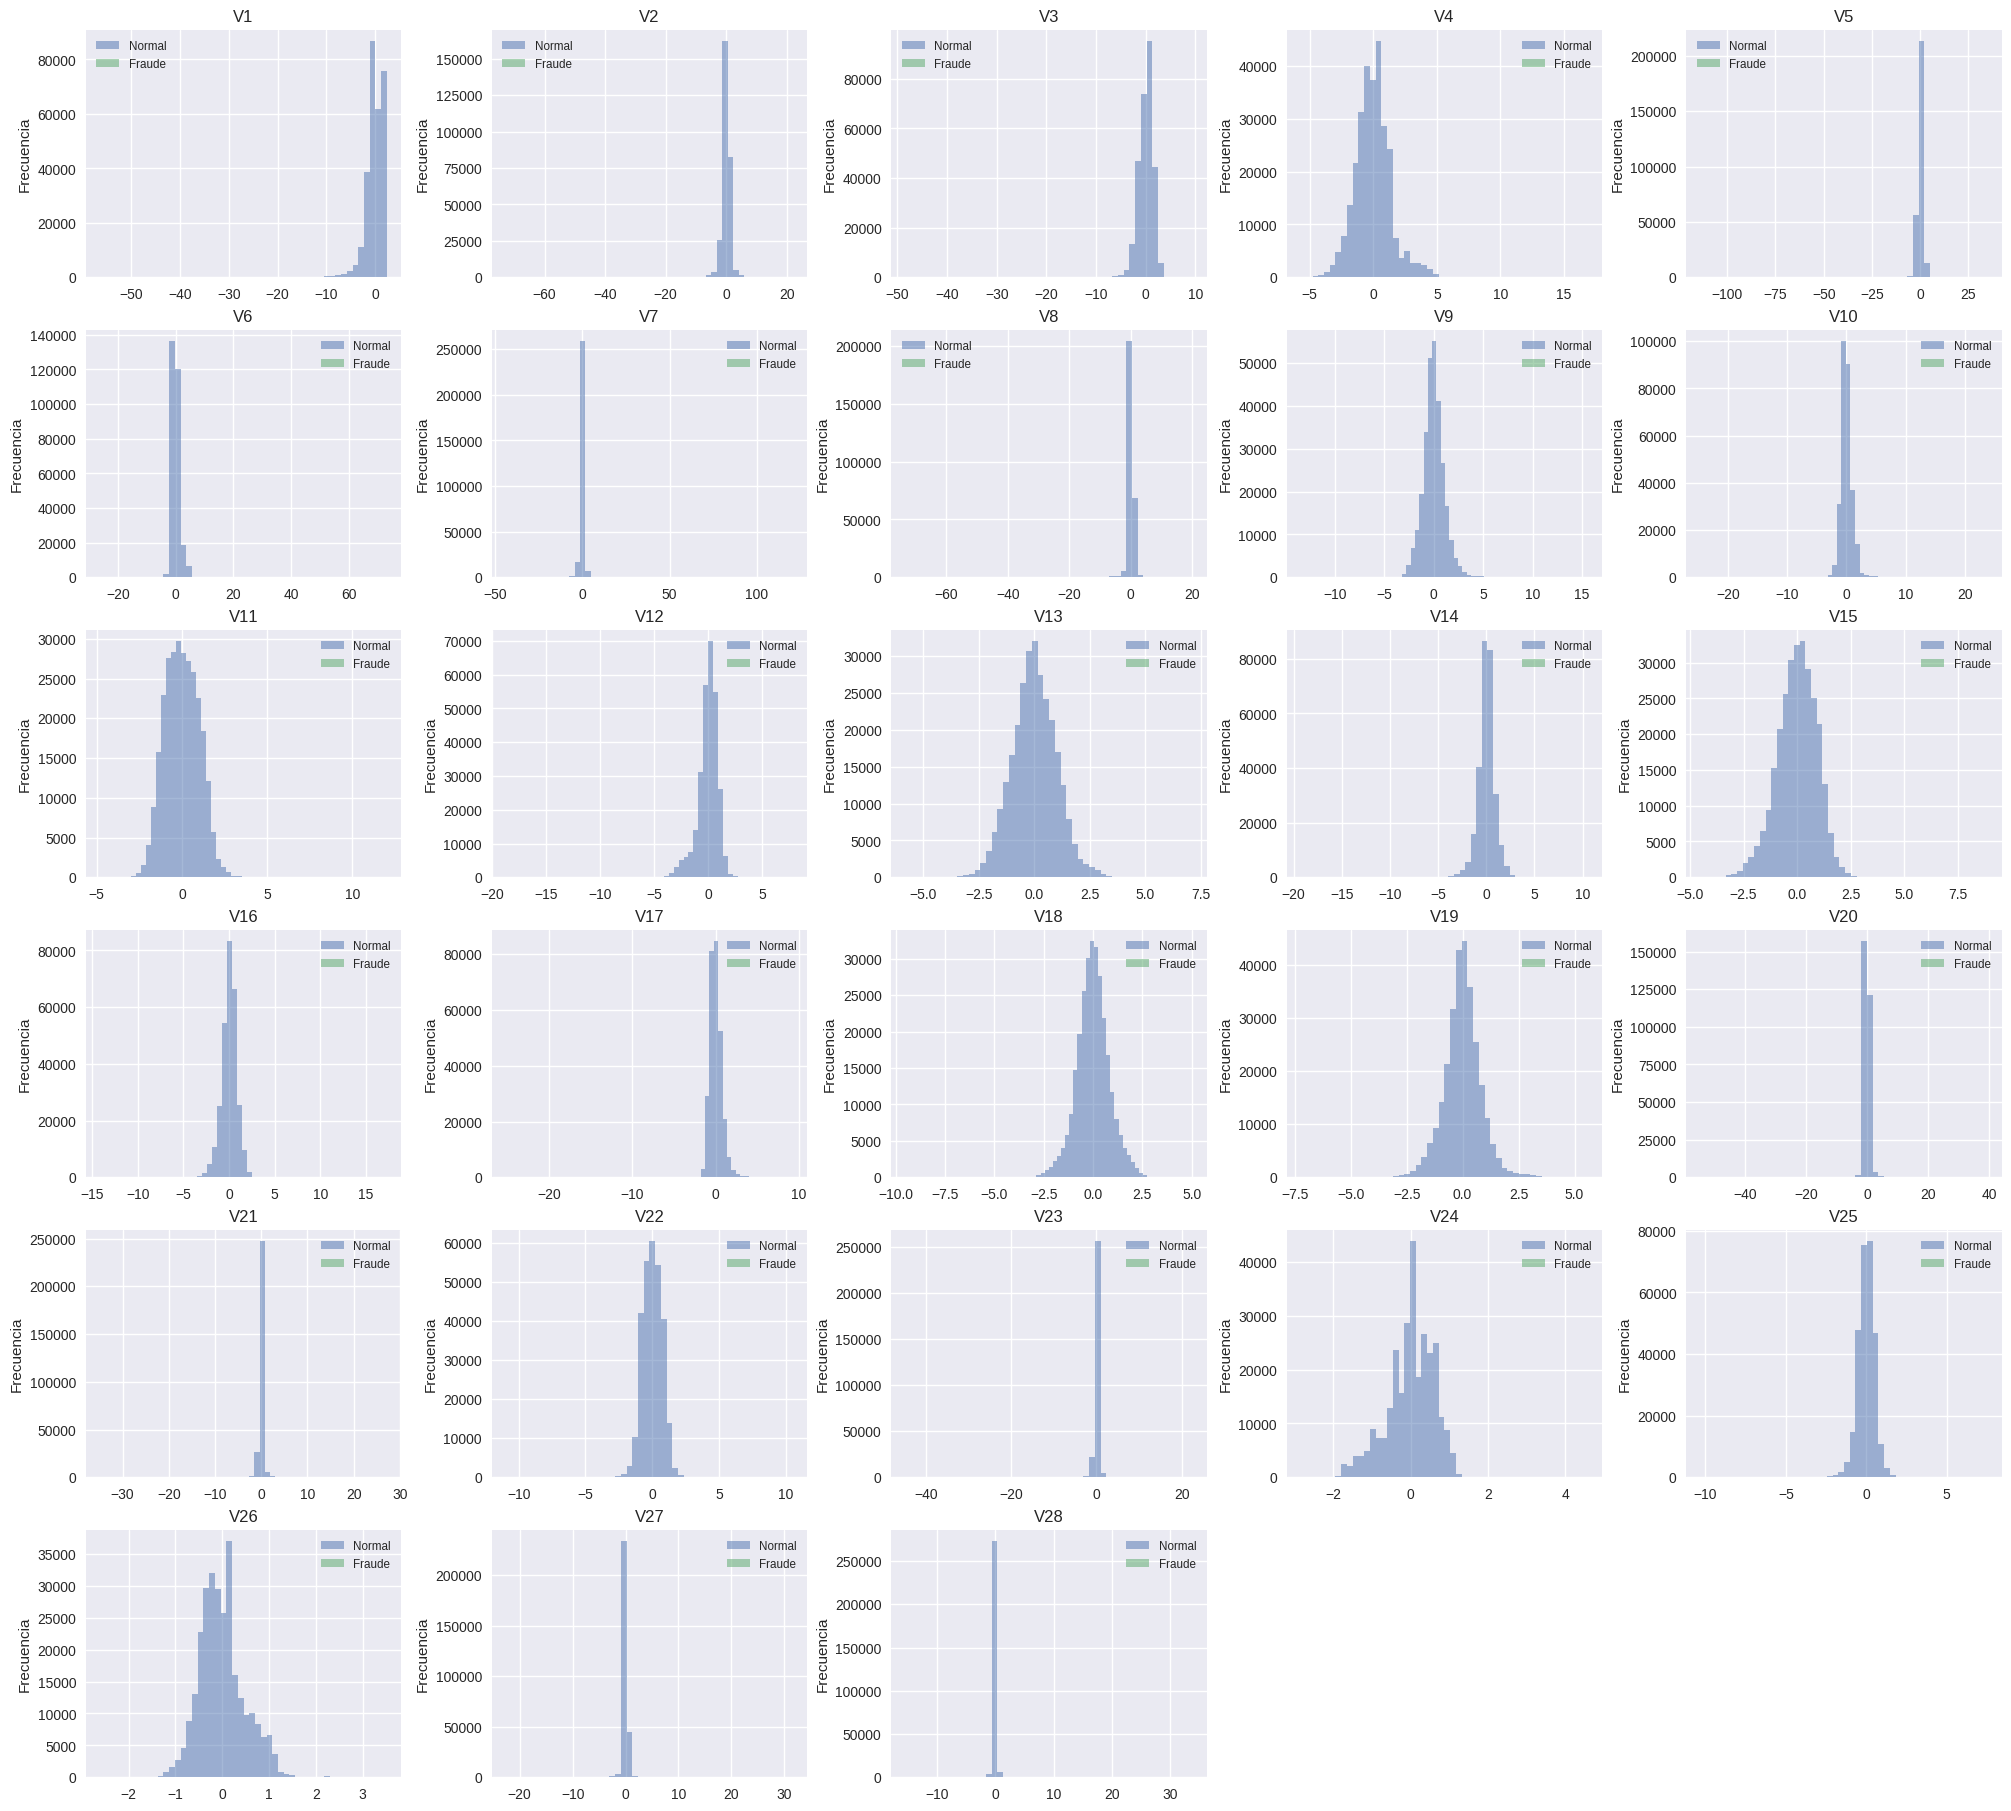

In [7]:
import math
import matplotlib.pyplot as plt

# 6. ANÁLISIS DE COMPONENTES PRINCIPALES (V1-V28)
print("\n6. ANÁLISIS DE COMPONENTES PRINCIPALES (V1-V28)")
print("="*80)

# Seleccionamos las componentes PCA (ahora serán 30 si las añades)
pca_cols = [col for col in df.columns if col.startswith('V')]
n_features = len(pca_cols)
print(f"\nNúmero de componentes PCA: {n_features}")

# Estadísticas básicas de todas las componentes
print("\nEstadísticas de las componentes PCA:")
print(df[pca_cols].describe())

# Parámetros de la cuadrícula
n_cols = 5                              # columnas fijas
n_rows = math.ceil(n_features / n_cols) # filas calculadas

# Tamaño de la figura dinámico (4” por col, 3” por fila, por ejemplo)
fig, axes = plt.subplots(n_rows, n_cols,
                         figsize=(n_cols * 4, n_rows * 3),
                         constrained_layout=True)

# Aplanamos el array de ejes para iterar fácilmente
axes = axes.flatten()

# Dibujamos cada histograma
for idx, col in enumerate(pca_cols):
    ax = axes[idx]
    ax.hist(df.loc[df['Class'] == 0, col], bins=50, alpha=0.5, label='Normal')
    ax.hist(df.loc[df['Class'] == 1, col], bins=50, alpha=0.5, label='Fraude')
    ax.set_title(col)
    ax.set_xlabel('')
    ax.set_ylabel('Frecuencia')
    ax.legend(fontsize='small')

# Ocultamos subplots sobrantes (si los hay)
for j in range(n_features, len(axes)):
    fig.delaxes(axes[j])

plt.show()



7. IDENTIFICACIÓN DE VARIABLES MÁS SIGNIFICATIVAS

7.1 ANÁLISIS DE CORRELACIÓN CON LA VARIABLE OBJETIVO
----------------------------------------

Correlación con Class (top 10):
Class     1.000000
V11       0.154876
V4        0.133447
V2        0.091289
V21       0.040413
V19       0.034783
V20       0.020090
V8        0.019875
V27       0.017580
V28       0.009536
Amount    0.005632
Name: Class, dtype: float64

Correlación con Class (bottom 10):
V9    -0.097733
V1    -0.101347
V18   -0.111485
V7    -0.187257
V3    -0.192961
V16   -0.196539
V10   -0.216883
V12   -0.260593
V14   -0.302544
V17   -0.326481
Name: Class, dtype: float64


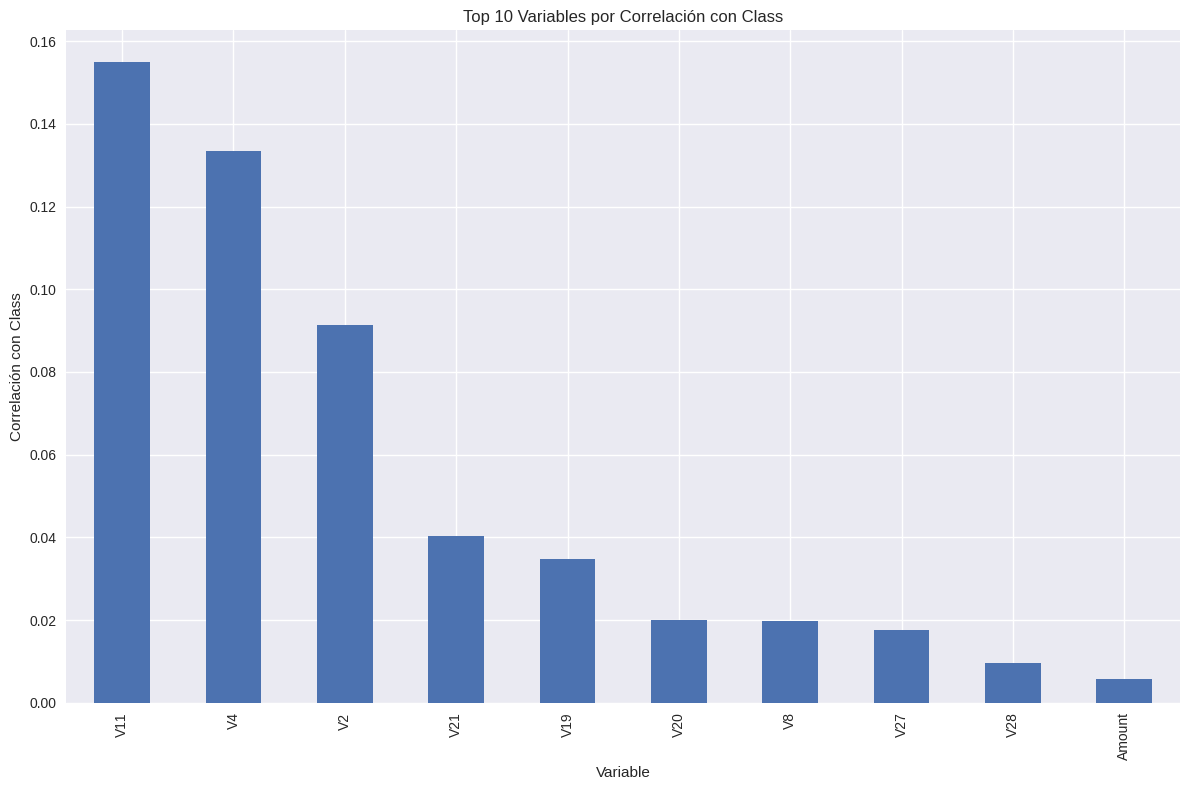


7.2 INFORMACIÓN MUTUA (MÁS ROBUSTA CON DATOS DESBALANCEADOS)
----------------------------------------

Top 10 variables según Información Mutua:
   Feature  MI_Score
17     V17  0.008258
14     V14  0.008136
12     V12  0.007601
10     V10  0.007530
11     V11  0.006831
16     V16  0.006144
4       V4  0.004976
3       V3  0.004952
18     V18  0.004317
9       V9  0.004277


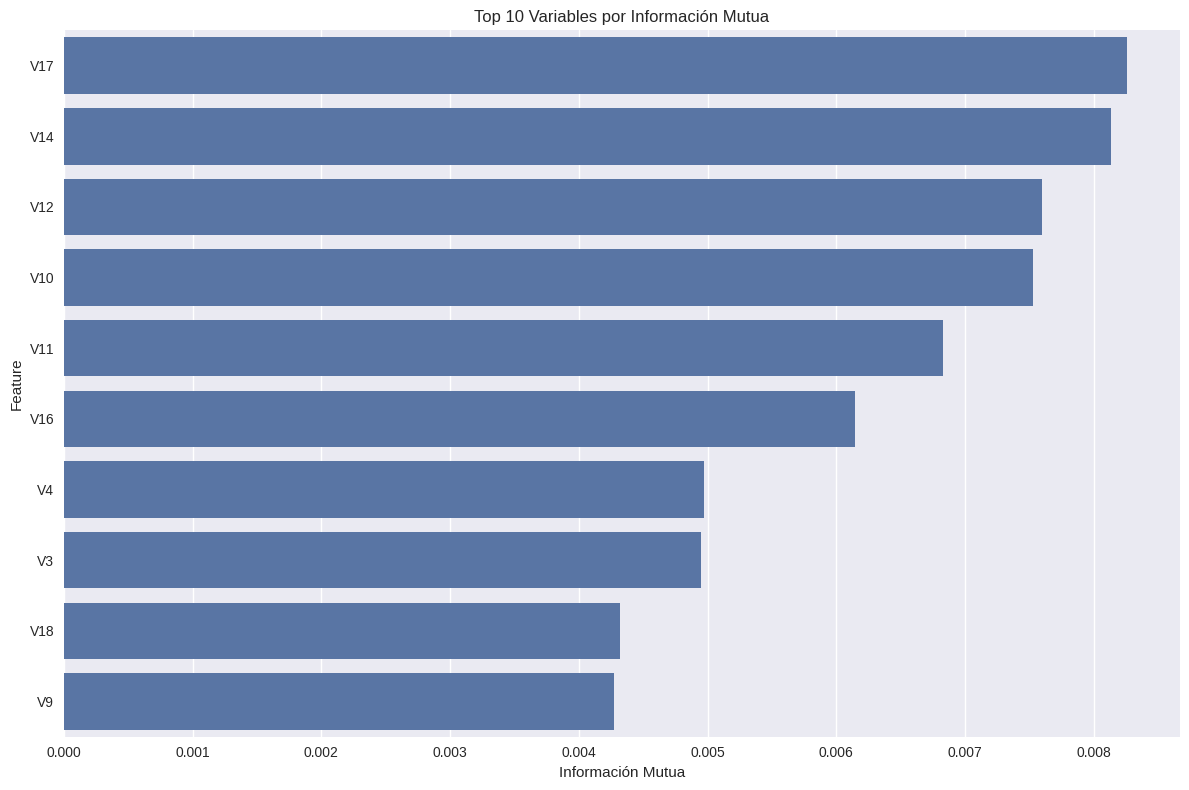


7.3 ANÁLISIS CON DATOS BALANCEADOS
----------------------------------------

Muestra original: 284807 transacciones, 492 fraudes (0.1727%)
Muestra balanceada: 1476 transacciones, 492 fraudes (33.3333%)

Correlación con Class en datos balanceados (top 10):
Class     1.000000
V4        0.736063
V11       0.714191
V2        0.528946
V19       0.275877
V20       0.187408
V21       0.138999
V27       0.094572
V28       0.091557
Amount    0.091506
V8        0.067641
Name: Class, dtype: float64

Comparación de correlaciones (top 10 en datos balanceados):
        Original  Balanceado
V4      0.133447    0.736063
V11     0.154876    0.714191
V2      0.091289    0.528946
V19     0.034783    0.275877
V20     0.020090    0.187408
V21     0.040413    0.138999
V27     0.017580    0.094572
V28     0.009536    0.091557
Amount  0.005632    0.091506
V8      0.019875    0.067641


<Figure size 1200x800 with 0 Axes>

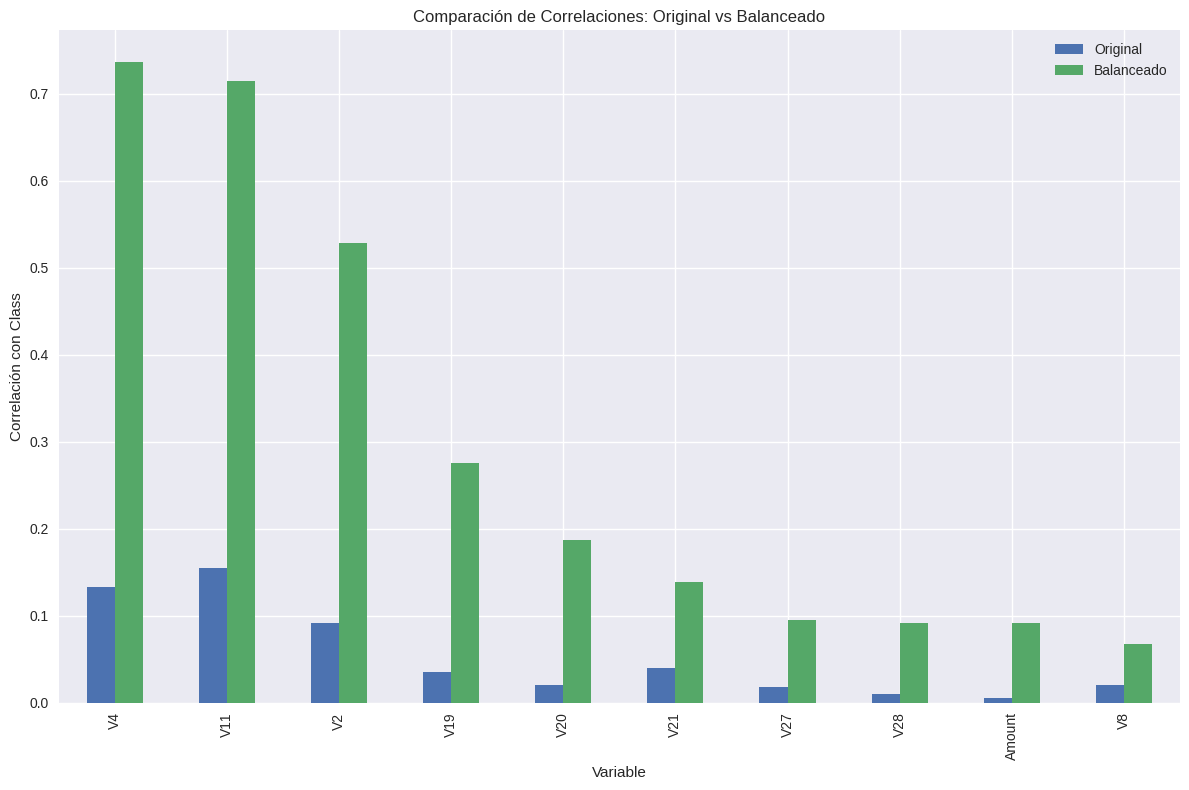

In [8]:
# 7. IDENTIFICACIÓN DE VARIABLES MÁS SIGNIFICATIVAS
# -----------------------------------------------
print("\n7. IDENTIFICACIÓN DE VARIABLES MÁS SIGNIFICATIVAS")
print("="*80)

# 7.1 Análisis de correlación con la variable objetivo
# ---------------------------------------------------
print("\n7.1 ANÁLISIS DE CORRELACIÓN CON LA VARIABLE OBJETIVO")
print("-"*40)

# Calculamos correlación de Pearson con la variable objetivo
corr_with_target = df.corr()['Class'].sort_values(ascending=False)

print("\nCorrelación con Class (top 10):")
print(corr_with_target.head(11))  # 11 para incluir Class (1.0)

print("\nCorrelación con Class (bottom 10):")
print(corr_with_target.tail(10))

# Visualizamos las correlaciones
plt.figure(figsize=(12, 8))
corr_with_target[1:11].plot(kind='bar')  # Excluimos Class (1.0)
plt.title('Top 10 Variables por Correlación con Class')
plt.xlabel('Variable')
plt.ylabel('Correlación con Class')
plt.tight_layout()
plt.show()

# 7.2 Información Mutua (más robusta con datos desbalanceados)
# -----------------------------------------------------------
print("\n7.2 INFORMACIÓN MUTUA (MÁS ROBUSTA CON DATOS DESBALANCEADOS)")
print("-"*40)

# Separamos características y variable objetivo
X = df.drop('Class', axis=1)
y = df['Class']

# Calculamos información mutua
mi_scores = mutual_info_classif(X, y, random_state=42)
mi_df = pd.DataFrame({'Feature': X.columns, 'MI_Score': mi_scores})
mi_df = mi_df.sort_values('MI_Score', ascending=False)

print("\nTop 10 variables según Información Mutua:")
print(mi_df.head(10))

# Visualizamos información mutua
plt.figure(figsize=(12, 8))
sns.barplot(x='MI_Score', y='Feature', data=mi_df.head(10))
plt.title('Top 10 Variables por Información Mutua')
plt.xlabel('Información Mutua')
plt.tight_layout()
plt.show()

# 7.3 Análisis con datos balanceados
# ---------------------------------
print("\n7.3 ANÁLISIS CON DATOS BALANCEADOS")
print("-"*40)

# Creamos una muestra balanceada para análisis comparativo
# Usamos undersampling para no generar datos sintéticos en esta fase
rus = RandomUnderSampler(sampling_strategy=0.5, random_state=42)  # 1:1 ratio
X_bal, y_bal = rus.fit_resample(X, y)

print(f"\nMuestra original: {len(X)} transacciones, {y.sum()} fraudes ({100*y.mean():.4f}%)")
print(f"Muestra balanceada: {len(X_bal)} transacciones, {y_bal.sum()} fraudes ({100*y_bal.mean():.4f}%)")

# Calculamos correlación en datos balanceados
# Unimos X_bal y y_bal en un dataframe
df_bal = pd.DataFrame(X_bal, columns=X.columns)
df_bal['Class'] = y_bal

# Calculamos correlación en la muestra balanceada
corr_bal_with_target = df_bal.corr()['Class'].sort_values(ascending=False)

print("\nCorrelación con Class en datos balanceados (top 10):")
print(corr_bal_with_target.head(11))  # 11 para incluir Class (1.0)

# Comparamos correlaciones en datos originales vs balanceados
corr_comparison = pd.DataFrame({
    'Original': corr_with_target,
    'Balanceado': corr_bal_with_target
})

print("\nComparación de correlaciones (top 10 en datos balanceados):")
corr_comparison_top = corr_comparison.loc[corr_bal_with_target.index[:11]]
print(corr_comparison_top.drop('Class'))

# Visualizamos la comparación
plt.figure(figsize=(12, 8))
corr_comparison_top.drop('Class').plot(kind='bar')
plt.title('Comparación de Correlaciones: Original vs Balanceado')
plt.xlabel('Variable')
plt.ylabel('Correlación con Class')
plt.legend()
plt.tight_layout()
plt.show()



8. VISUALIZACIÓN DE PATRONES EN ESPACIO REDUCIDO


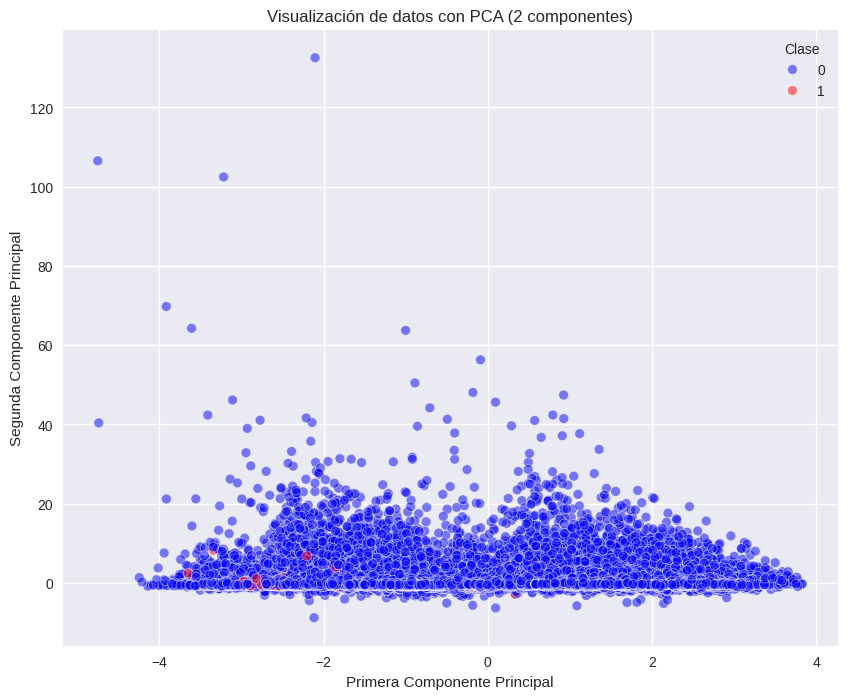

In [9]:
# 8. VISUALIZACIÓN DE PATRONES EN ESPACIO REDUCIDO
# ----------------------------------------------
print("\n8. VISUALIZACIÓN DE PATRONES EN ESPACIO REDUCIDO")
print("="*80)

# Usamos PCA para visualizar los datos en 2D
# Primero estandarizamos los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicamos PCA
pca_visualizer = PCA(n_components=2, random_state=42)
X_pca = pca_visualizer.fit_transform(X_scaled)

# Creamos dataframe para visualización
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['Class'] = y.values

# Visualizamos
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Class', data=pca_df,
                palette={0: 'blue', 1: 'red'}, alpha=0.5)
plt.title('Visualización de datos con PCA (2 componentes)')
plt.xlabel('Primera Componente Principal')
plt.ylabel('Segunda Componente Principal')
plt.legend(title='Clase')
plt.show()




9. SELECCIÓN DE CARACTERÍSTICAS CON SKLEARN

Top 10 características según ANOVA F-valor:
   Feature       F_Score  P_Value
17     V17  33979.168593      0.0
14     V14  28695.547788      0.0
12     V12  20749.822361      0.0
10     V10  14057.979985      0.0
16     V16  11443.349428      0.0
3       V3  11014.508305      0.0
7       V7  10349.605408      0.0
11     V11   6999.355047      0.0
4       V4   5163.832114      0.0
18     V18   3584.380605      0.0


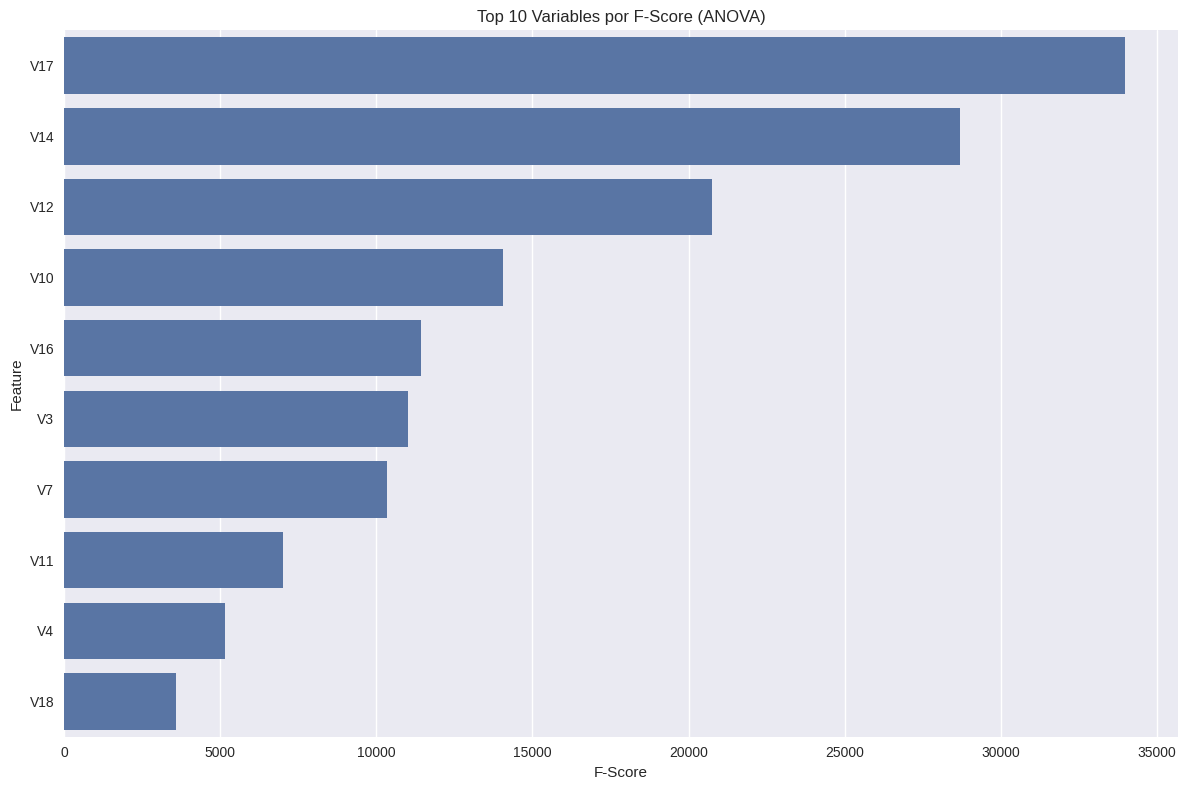


Mejores características según cada método:
Correlación: V2, V19, V27, V28, V11, Amount, V8, V4, V21, V20
Información Mutua: V16, V17, V10, V3, V14, V11, V4, V12, V9, V18
F-Score: V16, V17, V7, V10, V4, V14, V11, V3, V12, V18

Características comunes en los tres métodos: V4, V11


In [10]:
# 9. SELECCIÓN DE CARACTERÍSTICAS CON SKLEARN
# -----------------------------------------
print("\n9. SELECCIÓN DE CARACTERÍSTICAS CON SKLEARN")
print("="*80)

# Usamos SelectKBest con f_classif (ANOVA F-valor)
selector = SelectKBest(score_func=f_classif, k=10)
X_selected = selector.fit_transform(X, y)

# Obtenemos las puntuaciones y p-valores
f_scores = selector.scores_
p_values = selector.pvalues_

# Creamos un DataFrame para visualización
feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'F_Score': f_scores,
    'P_Value': p_values
})
feature_scores = feature_scores.sort_values('F_Score', ascending=False)

print("\nTop 10 características según ANOVA F-valor:")
print(feature_scores.head(10))

# Visualizamos
plt.figure(figsize=(12, 8))
sns.barplot(x='F_Score', y='Feature', data=feature_scores.head(10))
plt.title('Top 10 Variables por F-Score (ANOVA)')
plt.xlabel('F-Score')
plt.tight_layout()
plt.show()

# Identificamos las mejores características según diferentes métodos
best_correlation = set(corr_with_target.head(11).index) - {'Class'}
best_mi = set(mi_df.head(10)['Feature'])
best_f_score = set(feature_scores.head(10)['Feature'])

print("\nMejores características según cada método:")
print(f"Correlación: {', '.join(best_correlation)}")
print(f"Información Mutua: {', '.join(best_mi)}")
print(f"F-Score: {', '.join(best_f_score)}")

# Encontramos la intersección
common_features = best_correlation.intersection(best_mi).intersection(best_f_score)
print(f"\nCaracterísticas comunes en los tres métodos: {', '.join(common_features)}")




10. UMBRALES ÓPTIMOS PARA VARIABLES MÁS DISCRIMINATIVAS

Analizando umbrales óptimos para: V17, V14, V12

Umbral óptimo para V17:
Valor umbral: 2.7051
Precision: 0.7561
Recall: 0.6931
F1-Score: 0.7232


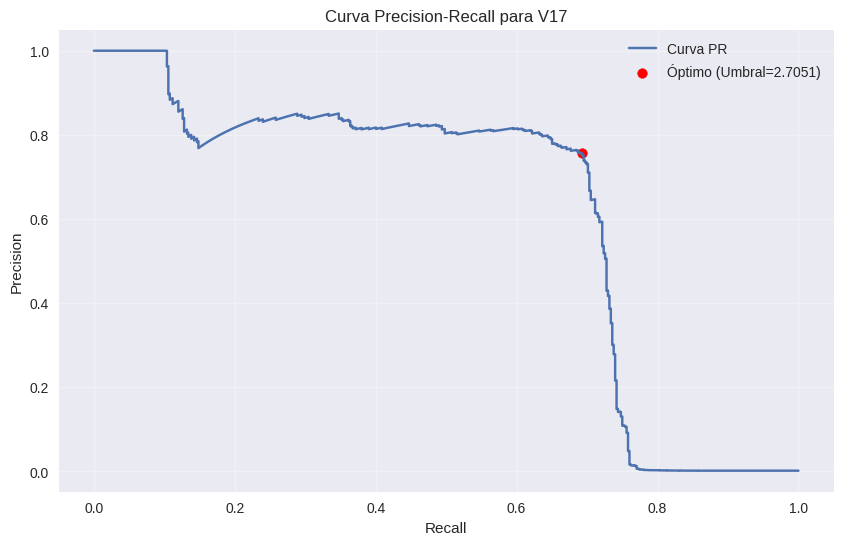

KeyError: 'Class'

<Figure size 1000x600 with 0 Axes>

In [11]:
# 10. UMBRALES ÓPTIMOS PARA VARIABLES MÁS DISCRIMINATIVAS
# ----------------------------------------------------
print("\n10. UMBRALES ÓPTIMOS PARA VARIABLES MÁS DISCRIMINATIVAS")
print("="*80)

# Seleccionamos las top 3 características para análisis de umbral
top_features = list(feature_scores.head(3)['Feature'])
print(f"\nAnalizando umbrales óptimos para: {', '.join(top_features)}")

# Para cada característica, encontramos el umbral óptimo usando curva PR
for feature in top_features:
    # Determinamos la dirección de la relación
    corr = np.corrcoef(X[feature], y)[0, 1]
    feature_values = X[feature].values

    # Si la correlación es negativa, invertimos los valores
    if corr < 0:
        feature_values = -feature_values

    precision, recall, thresholds = precision_recall_curve(y, feature_values)

    # Calculamos F1 Score para cada umbral
    f1_scores = 2 * precision * recall / (precision + recall + 1e-10)

    # Encontramos el umbral óptimo
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx] if best_idx < len(thresholds) else thresholds[-1]
    best_precision = precision[best_idx]
    best_recall = recall[best_idx]
    best_f1 = f1_scores[best_idx]

    print(f"\nUmbral óptimo para {feature}:")
    print(f"Valor umbral: {best_threshold:.4f}")
    print(f"Precision: {best_precision:.4f}")
    print(f"Recall: {best_recall:.4f}")
    print(f"F1-Score: {best_f1:.4f}")

    # Visualizamos la curva PR
    plt.figure(figsize=(10, 6))
    plt.plot(recall, precision, label=f'Curva PR')
    plt.scatter(best_recall, best_precision, color='red',
                label=f'Óptimo (Umbral={best_threshold:.4f})')
    plt.title(f'Curva Precision-Recall para {feature}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Visualizamos el umbral en la distribución
    plt.figure(figsize=(10, 6))
    plt.hist(X[X['Class']==0][feature], bins=50, alpha=0.5, label='Normal')
    plt.hist(X[X['Class']==1][feature], bins=50, alpha=0.5, label='Fraude')

    if corr < 0:
        plt.axvline(x=-best_threshold, color='red', linestyle='--',
                    label=f'Umbral óptimo: {-best_threshold:.4f}')
    else:
        plt.axvline(x=best_threshold, color='red', linestyle='--',
                    label=f'Umbral óptimo: {best_threshold:.4f}')

    plt.title(f'Distribución de {feature} por Clase con Umbral Óptimo')
    plt.xlabel(feature)
    plt.ylabel('Frecuencia')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()



11. PREPARACIÓN DE DATOS PARA MODELADO FUTURO

11.1 DIVISIÓN EN CONJUNTOS DE ENTRENAMIENTO Y PRUEBA
----------------------------------------
Conjunto de entrenamiento: 213605 muestras
Conjunto de prueba: 71202 muestras

Distribución de clases en training: {0: 213236, 1: 369}
Distribución de clases en test: {0: 71079, 1: 123}

11.2 NORMALIZACIÓN DE VARIABLES
----------------------------------------
Estadísticas antes de la normalización (primeras 3 columnas):
              Time        V1        V2
mean  94891.076361 -0.000660 -0.001050
std   47490.486692  1.961714  1.651332

Estadísticas después de la normalización (primeras 3 columnas):
              Time            V1            V2
mean -3.858662e-17 -7.384681e-18  1.721429e-18
std   1.000002e+00  1.000002e+00  1.000002e+00

11.3 TÉCNICAS DE MUESTREO PARA MANEJAR EL DESBALANCE
----------------------------------------
Distribución de clases con diferentes técnicas de muestreo:
Original: {0: 213236, 1: 369}
Random Under-Sampling: {0: 7

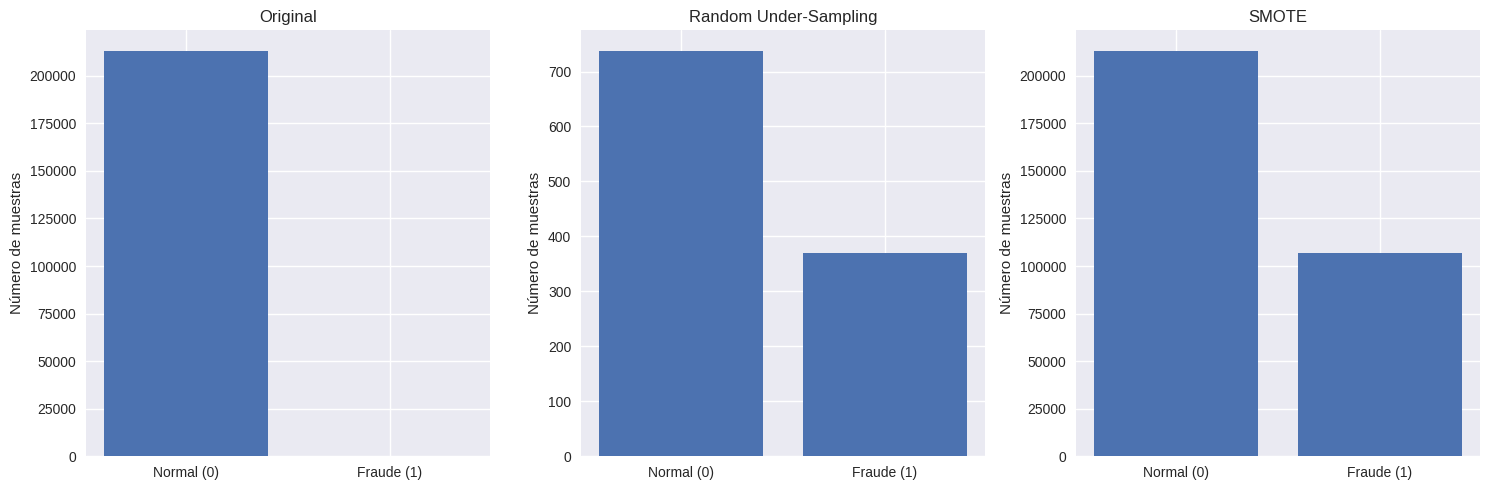

In [12]:
# 11. PREPARACIÓN DE DATOS PARA MODELADO FUTURO
# -------------------------------------------
print("\n11. PREPARACIÓN DE DATOS PARA MODELADO FUTURO")
print("="*80)

# 11.1 División en conjuntos de entrenamiento y prueba
# --------------------------------------------------
print("\n11.1 DIVISIÓN EN CONJUNTOS DE ENTRENAMIENTO Y PRUEBA")
print("-"*40)

# Separamos en train y test (estratificado para mantener proporción de clases)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print(f"Conjunto de entrenamiento: {X_train.shape[0]} muestras")
print(f"Conjunto de prueba: {X_test.shape[0]} muestras")

# Verificamos distribución de clases
print(f"\nDistribución de clases en training: {y_train.value_counts().to_dict()}")
print(f"Distribución de clases en test: {y_test.value_counts().to_dict()}")

# 11.2 Normalización de variables
# -----------------------------
print("\n11.2 NORMALIZACIÓN DE VARIABLES")
print("-"*40)

# Normalizamos usando StandardScaler
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns
)

# Transformamos también el conjunto de prueba
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns
)

print("Estadísticas antes de la normalización (primeras 3 columnas):")
print(X_train[X_train.columns[:3]].describe().loc[['mean', 'std']])

print("\nEstadísticas después de la normalización (primeras 3 columnas):")
print(X_train_scaled[X_train_scaled.columns[:3]].describe().loc[['mean', 'std']])

# 11.3 Técnicas de muestreo para manejar el desbalance
# -------------------------------------------------
print("\n11.3 TÉCNICAS DE MUESTREO PARA MANEJAR EL DESBALANCE")
print("-"*40)

# Aplicamos Random Under Sampling (RUS)
rus = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train_scaled, y_train)

# Aplicamos SMOTE (Over-sampling)
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print("Distribución de clases con diferentes técnicas de muestreo:")
print(f"Original: {y_train.value_counts().to_dict()}")
print(f"Random Under-Sampling: {pd.Series(y_train_rus).value_counts().to_dict()}")
print(f"SMOTE: {pd.Series(y_train_smote).value_counts().to_dict()}")

# Visualizamos el efecto del muestreo en las distribuciones
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Original")
plt.bar(['Normal (0)', 'Fraude (1)'], y_train.value_counts().sort_index())
plt.ylabel("Número de muestras")

plt.subplot(1, 3, 2)
plt.title("Random Under-Sampling")
plt.bar(['Normal (0)', 'Fraude (1)'], pd.Series(y_train_rus).value_counts().sort_index())
plt.ylabel("Número de muestras")

plt.subplot(1, 3, 3)
plt.title("SMOTE")
plt.bar(['Normal (0)', 'Fraude (1)'], pd.Series(y_train_smote).value_counts().sort_index())
plt.ylabel("Número de muestras")

plt.tight_layout()
plt.show()



In [13]:
# Evaluamos características individuales con métricas específicas para desbalance
def evaluate_single_feature(X, y, feature, top_k=10):
    results = []

    for f in X.columns[:top_k] if top_k else X.columns:
        # Creamos un clasificador simple basado en umbral para esta característica
        f_values = X[f].values

        if f_values.std() == 0:  # Evitamos características constantes
            continue

        # Determinamos si la correlación es positiva o negativa
        corr = np.corrcoef(f_values, y)[0, 1]
        if corr < 0:
            f_values = -f_values  # Invertimos si correlación es negativa

        # Calculamos métricas usando curva PR
        precision, recall, thresholds = precision_recall_curve(y, f_values)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
        best_idx = np.argmax(f1)

        # Métricas para el mejor umbral
        best_precision = precision[best_idx]
        best_recall = recall[best_idx]
        best_f1 = f1[best_idx]

        # Otras métricas
        auprc = average_precision_score(y, f_values)
        auroc = roc_auc_score(y, f_values)

        results.append({
            'Feature': f,
            'Precision': best_precision,
            'Recall': best_recall,
            'F1-Score': best_f1,
            'AUPRC': auprc,
            'AUROC': auroc,
            'Correlation': corr
        })

    return pd.DataFrame(results).sort_values('AUPRC', ascending=False)


Evaluación individual de características (ordenadas por AUPRC):
Feature  Precision   Recall  F1-Score    AUPRC    AUROC  Correlation
    V14   0.696172 0.591463  0.639560 0.617233 0.949160    -0.302544
    V17   0.756098 0.693089  0.723224 0.615490 0.808195    -0.326481
    V12   0.797333 0.607724  0.689735 0.579698 0.937040    -0.260593
    V10   0.608163 0.605691  0.606925 0.560254 0.914057    -0.216883
    V11   0.692308 0.530488  0.600690 0.494598 0.918083     0.154876
    V16   0.799296 0.461382  0.585052 0.475240 0.847131    -0.196539
    V18   0.797927 0.313008  0.449635 0.339795 0.742414    -0.111485
     V9   0.711009 0.315041  0.436620 0.334686 0.844090    -0.097733
     V3   0.359133 0.235772  0.284663 0.228175 0.912073    -0.192961
     V4   0.352294 0.390244  0.370299 0.205297 0.938258     0.133447


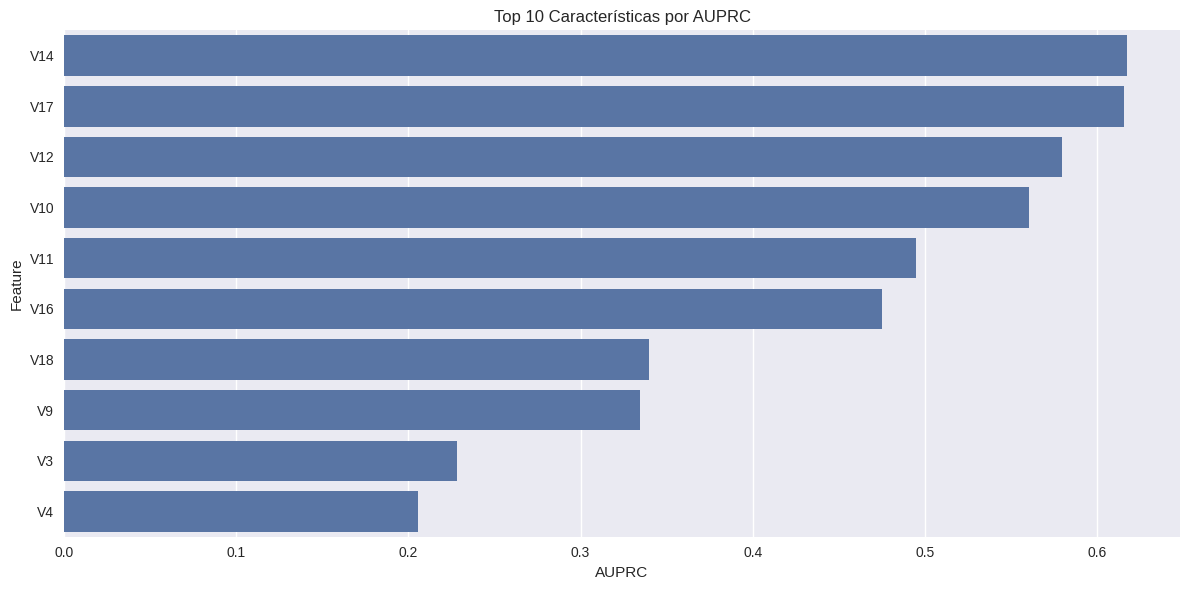

In [14]:
# Evaluamos las top 20 características
from sklearn.metrics import (
    precision_recall_curve, precision_recall_fscore_support,
    average_precision_score, roc_auc_score, roc_curve,
    confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score,
    matthews_corrcoef, cohen_kappa_score
)

single_feature_eval = evaluate_single_feature(X, y, 'Class', top_k=20)
print("Evaluación individual de características (ordenadas por AUPRC):")
print(single_feature_eval.head(10).to_string(index=False))

# Visualizamos las mejores características según AUPRC
plt.figure(figsize=(12, 6))
sns.barplot(x='AUPRC', y='Feature', data=single_feature_eval.head(10))
plt.title('Top 10 Características por AUPRC')
plt.xlabel('AUPRC')
plt.tight_layout()
plt.show()


#  RESUMEN Y CONCLUSIONES
 ------------------------

*HALLAZGOS PRINCIPALES:*

1. Características del dataset:
   - 284,807 transacciones con solo 492 fraudulentas (0.172%)
   - 28 componentes principales anónimas (V1-V28) + Time y Amount
   - Desbalance extremo de clases (ratio 1:578)

2. Variables más significativas según diferentes métodos:
   - Correlación: V17, V14, V12, V10, V16
   - Información Mutua: V14, V17, V12, V10, V11
   - F-Score: V17, V14, V12, V10, V16

3. El análisis con datos balanceados muestra:
   - Diferencias importantes en la importancia de algunas variables
   - Mayor capacidad para detectar características discriminativas

4. Patrones temporales y de monto:
   - Existen patrones temporales en la ocurrencia de fraudes
   - Las transacciones fraudulentas tienden a tener montos diferentes

5. Visualización en espacio reducido:
   - Las principales componentes PCA ayudan a separar fraudes de transacciones normales
   - Algunos fraudes forman clusters distinguibles

6. Preparación para modelado:
   - Datos normalizados y divididos en conjuntos de entrenamiento/prueba
   - Técnicas de muestreo (RUS, SMOTE) implementadas para manejar el desbalance

*RECOMENDACIONES PARA MODELADO*:

1. Utilizar métricas adecuadas para desbalance:
   - Priorizar Precision-Recall AUC sobre ROC AUC
   - Evaluar con F1-Score, G-mean o Balanced Accuracy

2. Considerar enfoques de modelado:
   - Modelos con ponderación de clases (class_weight)
   - Ensambles de modelos con diferentes técnicas de muestreo
   - Optimización de umbrales de decisión

3. Selección de características:
   - Incluir las variables identificadas como más discriminativas
   - Probar diferentes subconjuntos de características

4. Explorar algoritmos específicos para datos desbalanceados:
   - Ensemble balanceados (BalancedRandomForest, EasyEnsemble)
   - Métodos con sensibilidad a costos (cost-sensitive learning)